### A2C (image obs based CNN network)

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import imageio
from torch.distributions import Normal
import matplotlib.pyplot as plt
from metadrive.envs.top_down_env import TopDownMetaDrive

In [2]:

SEED = 42
TOTAL_EPOCHS = 120
EPISODES_PER_BATCH = 32
GAMMA = 0.875
GAE_LAMBDA = 0.95
ACTOR_LR = 8e-5
CRITIC_LR = 3e-3
SAVE_EVERY = 10
RENDER_EVERY = 20
MODEL_DIR = "a2c_checkpoints/models"
VIDEO_DIR = "a2c_checkpoints/videos"

np.random.seed(SEED)
torch.manual_seed(SEED)

def preprocess_obs(obs_list, device):
    return torch.tensor(np.stack(obs_list), dtype=torch.float32, device=device).permute(0, 3, 1, 2)

def compute_gae(rewards, values, gamma=GAMMA, lam=GAE_LAMBDA):
    advantages = []
    gae = 0
    values = values + [0.0]  # append 0 for terminal state
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] - values[t]
        gae = delta + gamma * lam * gae
        advantages.insert(0, gae)
    returns = [adv + val for adv, val in zip(advantages, values[:-1])]
    return advantages, returns


In [3]:
@torch.no_grad()
def record_video(actor, env, device, epoch, max_frames=1000):
    os.makedirs(VIDEO_DIR, exist_ok=True)
    frames = []
    obs, _ = env.reset()
    for _ in range(max_frames):
        obs_tensor = preprocess_obs([obs], device)
        mu, std = actor(obs_tensor)
        action = mu[0].cpu().numpy()
        img = env.render(mode="topdown")
        if img is not None:
            frames.append(img)
        obs, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    path = os.path.join(VIDEO_DIR, f"a2c_video_epoch_{epoch}.mp4")
    imageio.mimsave(path, frames, fps=20)
    print(f"[Video] Saved to {path}")


In [4]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(5, 16, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2), nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 9 * 9, 256), nn.ReLU()
        )
        self.mu = nn.Linear(256, 2)
        self.log_std = nn.Parameter(torch.full((2,), -0.5))

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        mu = self.mu(x)
        std = self.log_std.exp().expand_as(mu)
        return mu, std

class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(5, 16, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2), nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 9 * 9, 256), nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x).squeeze(-1)


In [5]:
def train(env):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    actor = Actor().to(device)
    critic = Critic().to(device)
    actor_optim = optim.Adam(actor.parameters(), lr=ACTOR_LR)
    critic_optim = optim.Adam(critic.parameters(), lr=CRITIC_LR)

    all_returns, actor_losses, critic_losses = [], [], []

    for epoch in range(1, TOTAL_EPOCHS + 1):
        batch_obs, batch_actions, batch_advantages, batch_returns = [], [], [], []
        returns = []

        for _ in range(EPISODES_PER_BATCH):
            obs_list, action_list, reward_list, value_list = [], [], [], []
            obs, _ = env.reset()
            done = False
            while not done:
                obs_tensor = preprocess_obs([obs], device)
                mu, std = actor(obs_tensor)
                dist = Normal(mu, std)
                action = dist.sample()[0].cpu().numpy()
                value = critic(obs_tensor).item()

                obs_list.append(obs)
                action_list.append(action)
                value_list.append(value)

                obs, reward, terminated, truncated, _ = env.step(action)
                reward_list.append(reward)
                done = terminated or truncated

            advs, rtgs = compute_gae(reward_list, value_list)
            batch_obs += obs_list
            batch_actions += action_list
            batch_advantages += advs
            batch_returns += rtgs
            returns.append(sum(reward_list))

        obs_tensor = preprocess_obs(batch_obs, device)
        act_tensor = torch.tensor(batch_actions, dtype=torch.float32, device=device)
        adv_tensor = torch.tensor(batch_advantages, dtype=torch.float32, device=device)
        rtg_tensor = torch.tensor(batch_returns, dtype=torch.float32, device=device)
        adv_tensor = (adv_tensor - adv_tensor.mean()) / (adv_tensor.std() + 1e-8)

        value = critic(obs_tensor)
        critic_loss = F.mse_loss(value, rtg_tensor)
        critic_optim.zero_grad()
        critic_loss.backward()
        critic_optim.step()

        mu, std = actor(obs_tensor)
        dist = Normal(mu, std)
        log_probs = dist.log_prob(act_tensor).sum(dim=-1)
        actor_loss = -(log_probs * adv_tensor).mean()
        actor_optim.zero_grad()
        actor_loss.backward()
        actor_optim.step()

        actor_losses.append(actor_loss.item())
        critic_losses.append(critic_loss.item())
        all_returns.append(np.mean(returns))

        print(f"Epoch {epoch}: Return={np.mean(returns):.2f}, Actor Loss={actor_loss.item():.4f}, Critic Loss={critic_loss.item():.4f}")

        if epoch % SAVE_EVERY == 0:
            os.makedirs(MODEL_DIR, exist_ok=True)
            torch.save(actor.state_dict(), os.path.join(MODEL_DIR, f"actor_epoch_{epoch}.pth"))
            torch.save(critic.state_dict(), os.path.join(MODEL_DIR, f"critic_epoch_{epoch}.pth"))

        if epoch % RENDER_EVERY == 0:
            record_video(actor, env, device, epoch)

    env.close()

    plt.plot(all_returns)
    plt.xlabel("Epoch")
    plt.ylabel("Average Return")
    plt.title("A2C Return")
    plt.grid()
    plt.show()

    plt.plot(actor_losses, label="Actor Loss")
    plt.plot(critic_losses, label="Critic Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("A2C Loss")
    plt.legend()
    plt.grid()
    plt.show()


In [6]:
def test_fixed_scenarios(fixed_scenarios, model_path, gif_dir="a2c_tests_gifs"):
    os.makedirs(gif_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    actor = Actor().to(device)
    actor.load_state_dict(torch.load(model_path))
    actor.eval()
    print(f"[INFO] Loaded actor from {model_path}")

    for scenario_id in fixed_scenarios:
        env = TopDownMetaDrive(dict(
            use_render=True,
            manual_control=False,
            horizon=500,
            num_scenarios=1,
            start_seed=scenario_id
        ))

        obs, _ = env.reset()
        rewards = []
        frames = []

        while True:
            frame = env.render(mode="topdown")
            if frame is not None:
                frames.append(frame)

            obs_tensor = preprocess_obs([obs], device)
            mu, std = actor(obs_tensor)
            dist = Normal(mu, std)
            action = torch.tanh(dist.mean)[0].detach().cpu().numpy()

            obs, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            if terminated or truncated:
                break


        env.close()
        gif_path = os.path.join(gif_dir, f"scenario_{scenario_id}.gif")
        imageio.mimsave(gif_path, frames, fps=20)
        print(f"Saved GIF for scenario {scenario_id} (reward={sum(rewards):.2f}) to {gif_path}")


[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 300
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 100
/var/folders/4r/46cgs67x2jb3cbzcd8tf87l80000gn/T/ipykernel_68051/3952095893.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  act_tensor = torch.tensor(batch_actions, dtype=torch.float32, device=device)


Epoch 1: Return=1.95, Actor Loss=0.0464, Critic Loss=0.0035
Epoch 2: Return=2.26, Actor Loss=0.0398, Critic Loss=0.1757
Epoch 3: Return=2.54, Actor Loss=0.0101, Critic Loss=0.0046
Epoch 4: Return=2.89, Actor Loss=0.0228, Critic Loss=0.0098
Epoch 5: Return=3.06, Actor Loss=0.0149, Critic Loss=0.0100
Epoch 6: Return=3.99, Actor Loss=0.0058, Critic Loss=0.0142
Epoch 7: Return=3.38, Actor Loss=-0.0111, Critic Loss=0.0179
Epoch 8: Return=3.29, Actor Loss=0.0122, Critic Loss=0.0347
Epoch 9: Return=4.42, Actor Loss=-0.0175, Critic Loss=0.0239
Epoch 10: Return=4.78, Actor Loss=-0.0074, Critic Loss=0.0329
Epoch 11: Return=5.07, Actor Loss=-0.0192, Critic Loss=0.0248
Epoch 12: Return=5.15, Actor Loss=-0.0160, Critic Loss=0.0532
Epoch 13: Return=5.32, Actor Loss=-0.0084, Critic Loss=0.0451
Epoch 14: Return=6.22, Actor Loss=-0.0293, Critic Loss=0.0453
Epoch 15: Return=6.57, Actor Loss=-0.0289, Critic Loss=0.0427
Epoch 16: Return=7.53, Actor Loss=-0.0179, Critic Loss=0.0514
Epoch 17: Return=6.79, A

2025-04-30 21:40:08.861 Python[68051:15535010] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


[Video] Saved to a2c_checkpoints/videos/a2c_video_epoch_20.mp4
Epoch 21: Return=9.15, Actor Loss=-0.0256, Critic Loss=0.1351
Epoch 22: Return=10.07, Actor Loss=-0.0447, Critic Loss=0.1167
Epoch 23: Return=11.86, Actor Loss=-0.0610, Critic Loss=0.1268
Epoch 24: Return=11.99, Actor Loss=-0.0337, Critic Loss=0.1262
Epoch 25: Return=14.30, Actor Loss=-0.0600, Critic Loss=0.1802
Epoch 26: Return=14.72, Actor Loss=-0.0405, Critic Loss=0.2914
Epoch 27: Return=14.23, Actor Loss=-0.0411, Critic Loss=0.3164
Epoch 28: Return=18.65, Actor Loss=-0.0739, Critic Loss=0.3138
Epoch 29: Return=13.67, Actor Loss=-0.0838, Critic Loss=0.5097
Epoch 30: Return=18.93, Actor Loss=-0.0504, Critic Loss=0.4923
Epoch 31: Return=23.69, Actor Loss=-0.0702, Critic Loss=0.5868
Epoch 32: Return=19.63, Actor Loss=-0.0669, Critic Loss=0.7858
Epoch 33: Return=17.97, Actor Loss=-0.0465, Critic Loss=0.9433
Epoch 34: Return=19.65, Actor Loss=-0.0708, Critic Loss=0.9692
Epoch 35: Return=20.36, Actor Loss=-0.0585, Critic Loss=

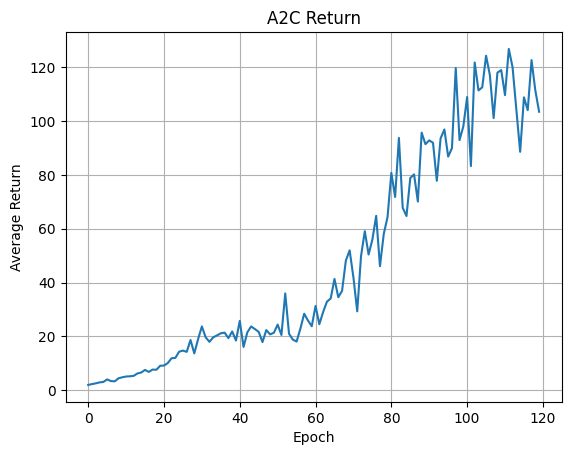

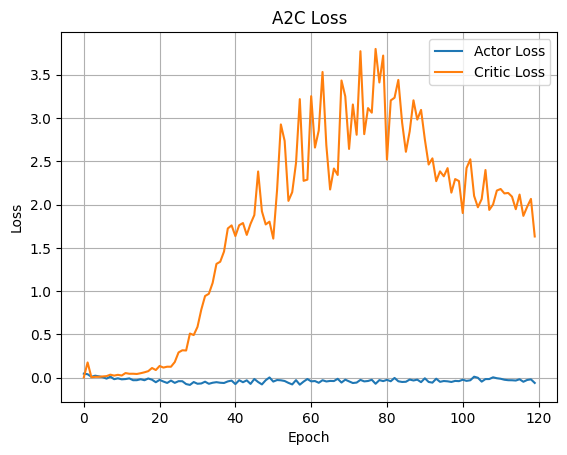

[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500
[INFO] Assets version: 0.4.3


[INFO] Loaded actor from a2c_checkpoints/models/actor_epoch_100.pth


[INFO] Known Pipes: CocoaGraphicsPipe
[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500


Saved GIF for scenario 0 (reward=63.28) to a2c_tests_gifs/scenario_0.gif


[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)
[INFO] Start Scenario Index: 5, Num Scenarios : 1
[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500
[INFO] Assets version: 0.4.3


Saved GIF for scenario 5 (reward=56.53) to a2c_tests_gifs/scenario_5.gif


[INFO] Known Pipes: CocoaGraphicsPipe
[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)
[INFO] Start Scenario Index: 12, Num Scenarios : 1
[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500


Saved GIF for scenario 12 (reward=68.41) to a2c_tests_gifs/scenario_12.gif


[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)
[INFO] Start Scenario Index: 37, Num Scenarios : 1
[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500


Saved GIF for scenario 37 (reward=48.49) to a2c_tests_gifs/scenario_37.gif


[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)
[INFO] Start Scenario Index: 89, Num Scenarios : 1


Saved GIF for scenario 89 (reward=143.52) to a2c_tests_gifs/scenario_89.gif


: 

In [ ]:
if __name__ == "__main__":
    env = TopDownMetaDrive(dict(use_render=False, horizon=300, num_scenarios=100))
    train(env)
    env.close()
    fixed_scenarios = [0, 5, 12, 37, 89]
    test_fixed_scenarios(fixed_scenarios, model_path="a2c_checkpoints/models/actor_epoch_100.pth")